In [1]:
import torch 
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor


print(torch.__version__)
print(torchvision.__version__)

c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.2.0.dev20230922+cu121
0.17.0.dev20230925+cu121


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [4]:
import os
import zipfile 
from pathlib import Path

import requests

# exanple source: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
    
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(target_file, "wb") as f:
            request = requests.get(source)
            f.write(request.content)
        
        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file}...")
            zip_ref.extractall(image_path)
        
        # Remove .zip file
        if remove_source:
            os.remove(target_file)
    
    return image_path

In [5]:
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi"
)

[INFO] data\pizza_steak_sushi directory exists, skipping download.


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [46]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

print(f"Manual transforms: {manual_transforms}")

Manual transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [47]:
from going_modular.data_setup import create_dataloaders


train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32,
    num_workers=0
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x247d1b59210>,
 ['pizza', 'steak', 'sushi'])

In [48]:
train_dir = image_path / "train"
test_dir = image_path / "test"

import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

automatic_transforms = weights.transforms()
automatic_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [49]:
for param in model.features.parameters():
    param.requires_grad = False
    

In [50]:
set_seeds()
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3, bias=True)
)

In [51]:
from torchinfo import summary

summary(model, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [53]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
writer 

In [54]:
from going_modular.engine import train_step, test_step

set_seeds()

import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New Experiment Tracking
        writer.add_scalars(main_tag="Loss", tag_scalar_dict={
            "train_loss": train_loss,
            "test_loss": test_loss
        }, global_step=epoch)

        writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={
            "train_acc": train_acc,
            "test_acc": test_acc
        }, global_step=epoch)

        writer.add_graph(model=model, input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    writer.close()

    # Return the filled results at the end of the epochs
    return results

In [55]:
set_seeds()

results = train(model=model, 
          train_dataloader=train_dataloader, 
          test_dataloader=test_dataloader, 
          optimizer=optimizer,
          loss_fn=loss_fn,
          epochs=5,
          device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085


 20%|██        | 1/5 [00:08<00:32,  8.13s/it]

Epoch: 2 | train_loss: 0.9036 | train_acc: 0.6484 | test_loss: 0.8006 | test_acc: 0.7642


 40%|████      | 2/5 [00:14<00:21,  7.30s/it]

Epoch: 3 | train_loss: 0.7953 | train_acc: 0.7422 | test_loss: 0.6742 | test_acc: 0.9176


 60%|██████    | 3/5 [00:20<00:13,  6.74s/it]

Epoch: 4 | train_loss: 0.6872 | train_acc: 0.8477 | test_loss: 0.6595 | test_acc: 0.8352


 80%|████████  | 4/5 [00:27<00:06,  6.50s/it]

Epoch: 5 | train_loss: 0.7181 | train_acc: 0.7188 | test_loss: 0.6551 | test_acc: 0.7945


100%|██████████| 5/5 [00:33<00:00,  6.63s/it]


In [61]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str,
                  model_name: str,
                  extra:str=None):
    """
    Creates a torch.utils.tensorboard.writer.SummaryWriter object to a specific
    """

    from datetime import datetime
    import os

    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Log directory: {log_dir}")
    return SummaryWriter(log_dir=log_dir)
    


In [62]:
example_writer = create_writer(experiment_name="data_10_percent", model_name="effnetb0", extra="5_epochs")
example_writer

[INFO] Log directory: runs\2023-10-22\data_10_percent\effnetb0\5_epochs


In [63]:
from going_modular.engine import train_step, test_step

set_seeds()

import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if(writer):
        ### New Experiment Tracking
            writer.add_scalars(main_tag="Loss", tag_scalar_dict={
                "train_loss": train_loss,
                "test_loss": test_loss
            }, global_step=epoch)

            writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={
                "train_acc": train_acc,
                "test_acc": test_acc
            }, global_step=epoch)

            writer.add_graph(model=model, input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
            writer.close()
        else:
            pass

    # Return the filled results at the end of the epochs
    return results

In [64]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
              destination="pizza_steak_sushi_20_percent")

[INFO] Did not find data\pizza_steak_sushi_20_percent directory, creating one...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip...


In [72]:
train_dir_10_percent = Path("data/pizza_steak_sushi/train")
train_dir_20_percent = Path("data/pizza_steak_sushi_20_percent/train")

test_dir = Path("data/pizza_steak_sushi/test")

train_dir_10_percent, train_dir_20_percent , test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [73]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [76]:
BATCH_SIZE = 32
from going_modular import data_setup

train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir_10_percent,
    test_dir = test_dir,
    transform = simple_transform,
    batch_size = BATCH_SIZE
)

train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir_20_percent,
    test_dir = test_dir,
    transform = simple_transform,
    batch_size = BATCH_SIZE
)

print(f"Number of batches in train dataloader: {len(train_dataloader_10_percent)}")
print(f"Number of batches in 20 percent train dataloader: {len(train_dataloader_20_percent)}")
print(f"Number of batches in test dataloader: {len(test_dataloader)}")
print(f"Class Names: {class_names}")


Number of batches in train dataloader: 8
Number of batches in 20 percent train dataloader: 15
Number of batches in test dataloader: 3
Class Names: ['pizza', 'steak', 'sushi']


In [ ]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

effnetb2_weights = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
effnetb2 = efficientnet_b2(weights="DEFAULT").to(device)
effnetb2

In [81]:
summary(effnetb2, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [91]:
import torchvision
from torch import nn 

OUT_FEATURES = len(class_names)

def create_effnetb0():
    from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
    from torchvision.models._api import WeightsEnum
    from torch.hub import load_state_dict_from_url

    def get_state_dict(self, *args, **kwargs):
        kwargs.pop("check_hash")
        return load_state_dict_from_url(self.url, *args, **kwargs)
    WeightsEnum.get_state_dict = get_state_dict

    weights = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    model = efficientnet_b0(weights="DEFAULT").to(device)

    for params in model.features.parameters():
        params.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    model.name="effnetb0"
    print(f"[INFO] Model name: {model.name}")
    return model
    

In [92]:
created_model_test = create_effnetb0()

[INFO] Model name: effnetb0


In [93]:
summary(created_model_test, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [94]:
import torchvision
from torch import nn 

OUT_FEATURES = len(class_names)

def create_effnetb2():
    from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
    from torchvision.models._api import WeightsEnum
    from torch.hub import load_state_dict_from_url

    def get_state_dict(self, *args, **kwargs):
        kwargs.pop("check_hash")
        return load_state_dict_from_url(self.url, *args, **kwargs)
    WeightsEnum.get_state_dict = get_state_dict

    weights = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
    model = efficientnet_b2(weights="DEFAULT").to(device)

    for params in model.features.parameters():
        params.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    model.name="effnetb2"
    print(f"[INFO] Model name: {model.name}")
    return model
    

In [97]:
created_model_test_effnetb2 = create_effnetb2()
created_model_test_effnetb0 = create_effnetb0()

[INFO] Model name: effnetb2
[INFO] Model name: effnetb0


In [99]:
summary(created_model_test_effnetb0, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [100]:
num_epochs = [5,10]

models = ["effnetb0", "effnetb2"]

train_dataloaders = {
    "data_10_percent" : train_dataloader_10_percent,
    "data_20_percent" : train_dataloader_20_percent,
}

In [105]:
from going_modular.utils import save_model

set_seeds()

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():
    for epochs in num_epochs:
        for model_name in models:
            experiment_number += 1
            print(f"[INFO] Training experiment number: {experiment_number} | {dataloader_name} | {epochs} epochs | {model_name}")

            if model_name == "effnetb0":
                model = create_effnetb0()
            elif model_name == "effnetb2":
                model = create_effnetb2()
            
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=epochs,
                device=device,
                writer=create_writer(
                    experiment_name=str(experiment_number),
                    model_name=model_name,
                    extra=f"{epochs}_epochs"
                )
                )
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}.pth"
            save_model(model=model,
                    target_dir="models",
                    model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Training experiment number: 1 | data_10_percent | 5 epochs | effnetb0
[INFO] Model name: effnetb0
[INFO] Log directory: runs\2023-10-23\1\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0167 | train_acc: 0.5039 | test_loss: 0.9255 | test_acc: 0.5900


 20%|██        | 1/5 [00:37<02:29, 37.36s/it]

Epoch: 2 | train_loss: 0.9524 | train_acc: 0.5469 | test_loss: 0.8075 | test_acc: 0.5890


 40%|████      | 2/5 [01:09<01:42, 34.21s/it]

Epoch: 3 | train_loss: 0.7661 | train_acc: 0.6914 | test_loss: 0.7270 | test_acc: 0.8561


 60%|██████    | 3/5 [01:42<01:07, 33.83s/it]

Epoch: 4 | train_loss: 0.7425 | train_acc: 0.6992 | test_loss: 0.6835 | test_acc: 0.8561


 80%|████████  | 4/5 [02:15<00:33, 33.29s/it]

Epoch: 5 | train_loss: 0.6465 | train_acc: 0.7656 | test_loss: 0.5825 | test_acc: 0.8665


100%|██████████| 5/5 [02:47<00:00, 33.54s/it]


[INFO] Saving model to: models\07_effnetb0_data_10_percent_5.pth
--------------------------------------------------

[INFO] Training experiment number: 2 | data_10_percent | 5 epochs | effnetb2
[INFO] Model name: effnetb2
[INFO] Log directory: runs\2023-10-23\2\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0197 | train_acc: 0.4766 | test_loss: 0.9462 | test_acc: 0.6420


 20%|██        | 1/5 [00:33<02:13, 33.26s/it]

Epoch: 2 | train_loss: 0.8924 | train_acc: 0.5391 | test_loss: 0.7869 | test_acc: 0.9167


 40%|████      | 2/5 [01:07<01:40, 33.63s/it]

Epoch: 3 | train_loss: 0.8131 | train_acc: 0.7266 | test_loss: 0.7700 | test_acc: 0.8258


 60%|██████    | 3/5 [01:40<01:07, 33.61s/it]

Epoch: 4 | train_loss: 0.7295 | train_acc: 0.7305 | test_loss: 0.7324 | test_acc: 0.8665


 80%|████████  | 4/5 [02:13<00:33, 33.38s/it]

Epoch: 5 | train_loss: 0.6252 | train_acc: 0.8945 | test_loss: 0.7109 | test_acc: 0.8456


100%|██████████| 5/5 [02:47<00:00, 33.44s/it]


[INFO] Saving model to: models\07_effnetb2_data_10_percent_5.pth
--------------------------------------------------

[INFO] Training experiment number: 3 | data_10_percent | 10 epochs | effnetb0
[INFO] Model name: effnetb0
[INFO] Log directory: runs\2023-10-23\3\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0510 | train_acc: 0.3633 | test_loss: 0.9212 | test_acc: 0.6307


 10%|█         | 1/10 [00:29<04:29, 29.93s/it]

Epoch: 2 | train_loss: 0.9366 | train_acc: 0.5859 | test_loss: 0.8596 | test_acc: 0.6108


 20%|██        | 2/10 [01:00<04:00, 30.08s/it]

Epoch: 3 | train_loss: 0.7719 | train_acc: 0.8203 | test_loss: 0.7374 | test_acc: 0.8248


 30%|███       | 3/10 [01:32<03:38, 31.22s/it]

Epoch: 4 | train_loss: 0.7038 | train_acc: 0.8203 | test_loss: 0.6917 | test_acc: 0.7841


 40%|████      | 4/10 [02:04<03:07, 31.26s/it]

Epoch: 5 | train_loss: 0.6561 | train_acc: 0.7578 | test_loss: 0.6083 | test_acc: 0.8665


 50%|█████     | 5/10 [02:35<02:36, 31.35s/it]

Epoch: 6 | train_loss: 0.6209 | train_acc: 0.8047 | test_loss: 0.5834 | test_acc: 0.8769


 60%|██████    | 6/10 [03:05<02:03, 30.88s/it]

Epoch: 7 | train_loss: 0.5378 | train_acc: 0.7891 | test_loss: 0.4892 | test_acc: 0.8968


 70%|███████   | 7/10 [03:37<01:33, 31.11s/it]

Epoch: 8 | train_loss: 0.5253 | train_acc: 0.8750 | test_loss: 0.5035 | test_acc: 0.8665


 80%|████████  | 8/10 [04:07<01:01, 30.94s/it]

Epoch: 9 | train_loss: 0.5265 | train_acc: 0.7891 | test_loss: 0.5633 | test_acc: 0.8561


 90%|█████████ | 9/10 [04:42<00:32, 32.06s/it]

Epoch: 10 | train_loss: 0.5327 | train_acc: 0.7891 | test_loss: 0.4399 | test_acc: 0.9280


100%|██████████| 10/10 [05:15<00:00, 31.51s/it]


[INFO] Saving model to: models\07_effnetb0_data_10_percent_10.pth
--------------------------------------------------

[INFO] Training experiment number: 4 | data_10_percent | 10 epochs | effnetb2
[INFO] Model name: effnetb2
[INFO] Log directory: runs\2023-10-23\4\effnetb2\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0513 | train_acc: 0.4258 | test_loss: 0.9336 | test_acc: 0.6913


 10%|█         | 1/10 [00:34<05:09, 34.33s/it]

Epoch: 2 | train_loss: 0.8665 | train_acc: 0.7109 | test_loss: 0.8559 | test_acc: 0.6515


 20%|██        | 2/10 [01:10<04:42, 35.30s/it]

Epoch: 3 | train_loss: 0.8303 | train_acc: 0.7070 | test_loss: 0.8266 | test_acc: 0.7131


 30%|███       | 3/10 [01:46<04:08, 35.57s/it]

Epoch: 4 | train_loss: 0.6672 | train_acc: 0.8555 | test_loss: 0.7019 | test_acc: 0.8655


 40%|████      | 4/10 [02:18<03:25, 34.22s/it]

Epoch: 5 | train_loss: 0.5705 | train_acc: 0.8633 | test_loss: 0.6497 | test_acc: 0.8864


 50%|█████     | 5/10 [02:54<02:55, 35.02s/it]

Epoch: 6 | train_loss: 0.6021 | train_acc: 0.7500 | test_loss: 0.6168 | test_acc: 0.8968


 60%|██████    | 6/10 [03:28<02:17, 34.47s/it]

Epoch: 7 | train_loss: 0.4867 | train_acc: 0.9180 | test_loss: 0.6409 | test_acc: 0.8561


 70%|███████   | 7/10 [04:00<01:41, 33.78s/it]

Epoch: 8 | train_loss: 0.5940 | train_acc: 0.7812 | test_loss: 0.6500 | test_acc: 0.8258


 80%|████████  | 8/10 [04:32<01:06, 33.35s/it]

Epoch: 9 | train_loss: 0.5028 | train_acc: 0.7891 | test_loss: 0.6241 | test_acc: 0.8049


 90%|█████████ | 9/10 [05:05<00:33, 33.21s/it]

Epoch: 10 | train_loss: 0.4808 | train_acc: 0.8164 | test_loss: 0.5776 | test_acc: 0.8665


100%|██████████| 10/10 [05:40<00:00, 34.05s/it]


[INFO] Saving model to: models\07_effnetb2_data_10_percent_10.pth
--------------------------------------------------

[INFO] Training experiment number: 5 | data_20_percent | 5 epochs | effnetb0
[INFO] Model name: effnetb0
[INFO] Log directory: runs\2023-10-23\5\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9483 | train_acc: 0.5917 | test_loss: 0.6470 | test_acc: 0.8958


 20%|██        | 1/5 [00:33<02:14, 33.60s/it]

Epoch: 2 | train_loss: 0.7070 | train_acc: 0.7896 | test_loss: 0.5433 | test_acc: 0.9176


 40%|████      | 2/5 [01:05<01:37, 32.46s/it]

Epoch: 3 | train_loss: 0.5482 | train_acc: 0.8521 | test_loss: 0.4518 | test_acc: 0.9280


 60%|██████    | 3/5 [01:35<01:03, 31.61s/it]

Epoch: 4 | train_loss: 0.4518 | train_acc: 0.9021 | test_loss: 0.4116 | test_acc: 0.9081


 80%|████████  | 4/5 [02:07<00:31, 31.48s/it]

Epoch: 5 | train_loss: 0.4635 | train_acc: 0.8646 | test_loss: 0.3501 | test_acc: 0.9280


100%|██████████| 5/5 [02:38<00:00, 31.76s/it]


[INFO] Saving model to: models\07_effnetb0_data_20_percent_5.pth
--------------------------------------------------

[INFO] Training experiment number: 6 | data_20_percent | 5 epochs | effnetb2
[INFO] Model name: effnetb2
[INFO] Log directory: runs\2023-10-23\6\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9905 | train_acc: 0.5229 | test_loss: 0.7684 | test_acc: 0.8873


 20%|██        | 1/5 [00:35<02:20, 35.10s/it]

Epoch: 2 | train_loss: 0.7165 | train_acc: 0.8604 | test_loss: 0.6601 | test_acc: 0.8873


 40%|████      | 2/5 [01:08<01:42, 34.01s/it]

Epoch: 3 | train_loss: 0.5813 | train_acc: 0.8708 | test_loss: 0.5979 | test_acc: 0.8674


 60%|██████    | 3/5 [01:42<01:07, 33.98s/it]

Epoch: 4 | train_loss: 0.5001 | train_acc: 0.8667 | test_loss: 0.5037 | test_acc: 0.9176


 80%|████████  | 4/5 [02:16<00:33, 33.97s/it]

Epoch: 5 | train_loss: 0.4589 | train_acc: 0.8854 | test_loss: 0.5319 | test_acc: 0.8977


100%|██████████| 5/5 [02:48<00:00, 33.67s/it]


[INFO] Saving model to: models\07_effnetb2_data_20_percent_5.pth
--------------------------------------------------

[INFO] Training experiment number: 7 | data_20_percent | 10 epochs | effnetb0
[INFO] Model name: effnetb0
[INFO] Log directory: runs\2023-10-23\7\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9623 | train_acc: 0.6104 | test_loss: 0.7542 | test_acc: 0.8456


 10%|█         | 1/10 [00:36<05:31, 36.78s/it]

Epoch: 2 | train_loss: 0.6710 | train_acc: 0.8417 | test_loss: 0.5918 | test_acc: 0.9081


 20%|██        | 2/10 [01:10<04:41, 35.15s/it]

Epoch: 3 | train_loss: 0.5506 | train_acc: 0.8646 | test_loss: 0.5123 | test_acc: 0.8769


 30%|███       | 3/10 [01:46<04:07, 35.35s/it]

Epoch: 4 | train_loss: 0.4780 | train_acc: 0.8333 | test_loss: 0.4949 | test_acc: 0.8873


 40%|████      | 4/10 [02:17<03:22, 33.76s/it]

Epoch: 5 | train_loss: 0.4080 | train_acc: 0.8938 | test_loss: 0.4116 | test_acc: 0.8873


 50%|█████     | 5/10 [02:49<02:45, 33.07s/it]

Epoch: 6 | train_loss: 0.4162 | train_acc: 0.8646 | test_loss: 0.3695 | test_acc: 0.8968


 60%|██████    | 6/10 [03:19<02:08, 32.12s/it]

Epoch: 7 | train_loss: 0.3702 | train_acc: 0.8812 | test_loss: 0.3804 | test_acc: 0.9081


 70%|███████   | 7/10 [03:50<01:34, 31.55s/it]

Epoch: 8 | train_loss: 0.3911 | train_acc: 0.8958 | test_loss: 0.3144 | test_acc: 0.9072


 80%|████████  | 8/10 [04:20<01:02, 31.23s/it]

Epoch: 9 | train_loss: 0.3168 | train_acc: 0.9187 | test_loss: 0.3420 | test_acc: 0.9489


 90%|█████████ | 9/10 [04:51<00:31, 31.17s/it]

Epoch: 10 | train_loss: 0.3152 | train_acc: 0.9229 | test_loss: 0.3006 | test_acc: 0.9384


100%|██████████| 10/10 [05:21<00:00, 32.16s/it]


[INFO] Saving model to: models\07_effnetb0_data_20_percent_10.pth
--------------------------------------------------

[INFO] Training experiment number: 8 | data_20_percent | 10 epochs | effnetb2
[INFO] Model name: effnetb2
[INFO] Log directory: runs\2023-10-23\8\effnetb2\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9988 | train_acc: 0.5417 | test_loss: 0.7906 | test_acc: 0.8864


 10%|█         | 1/10 [00:31<04:46, 31.83s/it]

Epoch: 2 | train_loss: 0.7430 | train_acc: 0.7812 | test_loss: 0.6864 | test_acc: 0.9072


 20%|██        | 2/10 [01:02<04:11, 31.41s/it]

Epoch: 3 | train_loss: 0.6651 | train_acc: 0.8292 | test_loss: 0.5653 | test_acc: 0.9384


 30%|███       | 3/10 [01:36<03:45, 32.17s/it]

Epoch: 4 | train_loss: 0.5166 | train_acc: 0.8688 | test_loss: 0.5733 | test_acc: 0.8769


 40%|████      | 4/10 [02:08<03:13, 32.30s/it]

Epoch: 5 | train_loss: 0.5164 | train_acc: 0.8562 | test_loss: 0.4871 | test_acc: 0.9280


 50%|█████     | 5/10 [02:39<02:39, 31.95s/it]

Epoch: 6 | train_loss: 0.4069 | train_acc: 0.9167 | test_loss: 0.4586 | test_acc: 0.9176


 60%|██████    | 6/10 [03:11<02:07, 31.77s/it]

Epoch: 7 | train_loss: 0.3661 | train_acc: 0.9333 | test_loss: 0.4263 | test_acc: 0.9384


 70%|███████   | 7/10 [03:42<01:34, 31.59s/it]

Epoch: 8 | train_loss: 0.3325 | train_acc: 0.9083 | test_loss: 0.4260 | test_acc: 0.9176


 80%|████████  | 8/10 [04:13<01:03, 31.52s/it]

Epoch: 9 | train_loss: 0.3356 | train_acc: 0.9167 | test_loss: 0.3989 | test_acc: 0.9280


 90%|█████████ | 9/10 [04:44<00:31, 31.34s/it]

Epoch: 10 | train_loss: 0.3075 | train_acc: 0.9396 | test_loss: 0.3976 | test_acc: 0.9280


100%|██████████| 10/10 [05:16<00:00, 31.64s/it]

[INFO] Saving model to: models\07_effnetb2_data_20_percent_10.pth
--------------------------------------------------



In [107]:
best_model_path = "models/07_effnetb0_data_10_percent_10.pth"

best_model = create_effnetb0()

best_model.load_state_dict(torch.load(best_model_path))

[INFO] Model name: effnetb0


<All keys matched successfully>

In [108]:
from pathlib import Path

effnetb0_model_size = Path(best_model_path).stat().st_size / 1000000
print(f"Model size: {effnetb0_model_size} MB")

Model size: 16.352342 MB


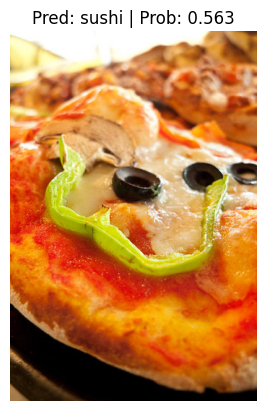

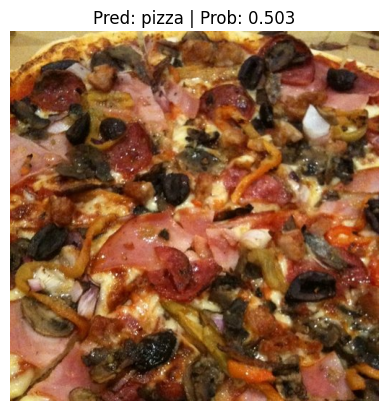

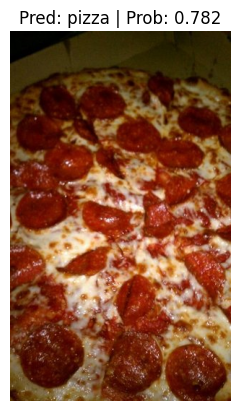

In [109]:
from going_modular.predictions import pred_and_plot_image

import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path/"test").glob("*/*.jpg"))

test_image_path_sample = random.sample(test_image_path_list, num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        device=device)


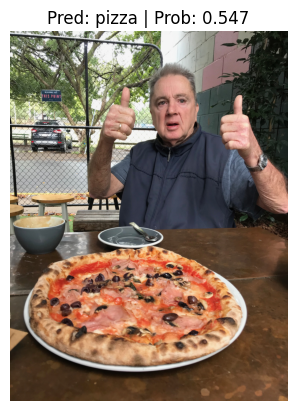

In [112]:
pred_and_plot_image(model=best_model,
                        image_path=Path("data/04-pizza-dad.jpeg"),
                        class_names=class_names,
                        device=device)